In [1]:
# download data
import os
from glob import glob
os.chdir('/content/')
!rm -rf Satellite-Segmentation
!git clone https://github.com/JasonChu1313/Satellite-Segmentation.git
import os 
os.chdir('/content/Satellite-Segmentation')
!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/

!kaggle competitions download -c comp-540-spring-2019
!mkdir data
!mv train.zip ./data/
!mv val.zip ./data/
os.chdir("./data")
!unzip val.zip
!unzip train.zip

Cloning into 'Satellite-Segmentation'...
remote: Enumerating objects: 482, done.
remote: Total 482 (delta 0), reused 0 (delta 0), pack-reused 482
Receiving objects: 100% (482/482), 834.03 KiB | 6.84 MiB/s, done.
Resolving deltas: 100% (323/323), done.
 76% 17.0M/22.5M [00:00<00:00, 44.5MB/s]
100% 22.5M/22.5M [00:00<00:00, 56.8MB/s]
 97% 456M/470M [00:03<00:00, 164MB/s]
100% 470M/470M [00:03<00:00, 159MB/s]
 94% 83.0M/88.6M [00:00<00:00, 82.1MB/s]
100% 88.6M/88.6M [00:01<00:00, 90.8MB/s]
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
Archive:  val.zip
   creating: val/
  inflating: val/68707_sat.jpg       
  inflating: val/68711_sat.jpg       
  inflating: val/68720_sat.jpg       
  inflating: val/68729_sat.jpg       
  inflating: val/68731_sat.jpg       
  inflating: val/68733_sat.jpg       
  inflating: val/68738_sat.jpg       
  inflating: val/68743_sat.jpg       
  inflating: val/68752_sat.jpg       
  inflating: val/68756_sa

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [3]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 21.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [4]:
# https://drive.google.com/open?id=1sm9jj4yZbnUfWmiE3WFAgYr_VaNgQXq3
# id55-15-0.1972.h5
model = drive.CreateFile({'id':'1sm9jj4yZbnUfWmiE3WFAgYr_VaNgQXq3'})
model.GetContentFile('id55-15-0.1972.h5')

import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

smooth = 1e-9

# This is the competition metric implemented using Keras
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# We'll construct a Keras Loss that incorporates the DICE score
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1. - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


def bce_dice_loss(y_true, y_pred):
    return 0.45 * binary_crossentropy(y_true, y_pred) + 0.55 * dice_loss(y_true, y_pred)
  
def ln_dice(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred = K.cast(y_pred, 'float32')
  y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
  intersection = y_true_f * y_pred_f
  score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  return K.log(score)

def new_bce_dice_loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) - ln_dice(y_true, y_pred)
  

model = load_model('id55-15-0.1972.h5', custom_objects={'bce_dice_loss':bce_dice_loss,'dice_coef':dice_coef})


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
def val_img_gen(val_img_paths,img_size=(512,512)):
  for i, val_img_path in enumerate(val_img_paths):
    img = imread(val_img_path)/255
    img = resize(img, img_size, preserve_range = True)
    img = np.reshape(img, (1,512,512,3))
    yield img
    
def predict_on_image(img_id, data_path, show = False):
  img_path = os.path.join(data_path,img_id+'_sat.jpg')
  mask_path = os.path.join(data_path,img_id+'_msk.png')
  origin_image = imread(img_path)
  mask_image = imread(mask_path)
  
  val_img_paths = [img_path]
  vig = val_img_gen(val_img_paths)
  result = model.predict_generator(vig,steps = len(val_img_paths), max_queue_size=5, workers=1, use_multiprocessing=False, verbose=1)[0]
  
  predict_img_origin = np.concatenate([result,result,result],axis = -1)
  
  predict_img = (predict_img_origin >= 0.5).astype(float)
  
  predict_img *=255
  
  vig_1 = val_img_gen(val_img_paths)
  result_1 = model.predict_generator(vig_1,steps = len(val_img_paths), max_queue_size=5, workers=1, use_multiprocessing=False, verbose=1)[0]
  predict_img_1 = np.concatenate([result_1,result_1,result_1],axis = -1)
  predict_img_1 = (predict_img_1 >= 0.5).astype(float)
  
  predict_img_1 *=255
  
  
  if show:
    fig, axes = plt.subplots(1,4, figsize = (20,80))
    axes[0].imshow(origin_image)
    axes[1].imshow(mask_image)
    axes[2].imshow(predict_img)
    axes[3].imshow(predict_img_1)
  return origin_image, mask_image, result

In [6]:
os.chdir("/content/")
origin_image, mask_image, pred_result = predict_on_image('39488','./Satellite-Segmentation/data/train/')

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1/1 [==============================] - 0s 395ms/step


In [7]:
!pip install pydensecrf

    100% |████████████████████████████████| 1.0MB 20.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/92/6f/ec/5c49c25de8c42c872de50ff53582ba3ead850ce52a81e73ac7
Successfully built pydensecrf


In [0]:
import sys
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian, softmax_to_unary
import skimage.io as io

def CRF(image,pred_result,mask_image):
  processed_probabilities = np.concatenate([pred_result, 1-pred_result], axis = -1)
  mask_image = np.reshape(mask_image[:,:,0],(image.shape[0],image.shape[1]))
  
  softmax = processed_probabilities.squeeze()

  softmax = softmax.transpose((2, 0, 1))

  # The input should be the negative of the logarithm of probability values
  # Look up the definition of the softmax_to_unary for more information
  unary = softmax_to_unary(processed_probabilities)

  # The inputs should be C-continious -- we are using Cython wrapper
  unary = np.ascontiguousarray(unary)
  
  unary = np.reshape(unary,(2,image.shape[0] * image.shape[1]))

  d = dcrf.DenseCRF(image.shape[0] * image.shape[1], 2)

  d.setUnaryEnergy(unary)

  # This potential penalizes small pieces of segmentation that are
  # spatially isolated -- enforces more spatially consistent segmentations
  feats = create_pairwise_gaussian(sdims=(10, 10), shape=image.shape[:2])

  d.addPairwiseEnergy(feats, compat=50,
                      kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)

  # This creates the color-dependent features --
  # because the segmentation that we get from CNN are too coarse
  # and we can use local color features to refine them
  feats = create_pairwise_bilateral(sdims=(50, 50), schan=(20, 20, 20),
                                     img=image, chdim=2)
    
  d.addPairwiseEnergy(feats, compat=50,
                       kernel=dcrf.DIAG_KERNEL,
                       normalization=dcrf.NORMALIZE_SYMMETRIC)
  Q = d.inference(5)

  res = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

  cmap = plt.get_cmap('bwr')

  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
  
  ax1.imshow(np.reshape(pred_result,(image.shape[0],image.shape[1])), vmax=1.5, vmin=-0.4, cmap=cmap)
  ax1.set_title('Segmentation result')
  
  ax2.imshow(res, vmax=1.5, vmin=-0.4, cmap=cmap)
  ax2.set_title('Segmentation with CRF post-processing')
  
  probability_graph = ax3.imshow(mask_image*255, vmax=1.5, vmin=-0.4, cmap=cmap)
  ax3.set_title('Ground-Truth Annotation')
  plt.show()



/usr/local/lib/python3.6/dist-packages/pydensecrf/utils.py:79: RuntimeWarning: divide by zero encountered in log
  return -np.log(sm).reshape([num_cls, -1]).astype(np.float32)


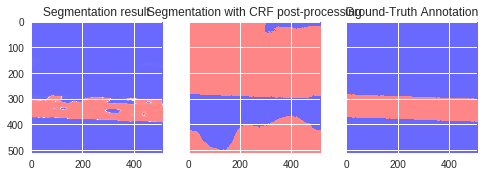

In [10]:
CRF(origin_image,pred_result,mask_image)

In [0]:
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
%matplotlib inline
"""
used for converting the decoded image to rle mask

"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    mask_img = np.reshape(mask_img, (original_image.shape[0],original_image.shape[1] ))
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.FULL_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
    
     #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [0]:

smooth = 1e-9
from keras.losses import binary_crossentropy

# This is the competition metric implemented using Keras
def dice_coef_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred = y_pred.astype('float')
    y_pred_f = np.greater(y_pred.flatten(), 0.5).astype('float')
    intersection = y_true_f * y_pred_f
    score = 2. * (np.sum(intersection) + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)
    return score

In [0]:
def show_crf(img_id, data_path = "./Satellite-Segmentation/data/train/" ):
  """
    pred_result: (512,512,1) 0 - 1
    origin_image: (512,512,3) rgb
  """
  origin_image, mask_image, pred_result = predict_on_image(img_id, data_path)
  f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize = (20,80))
  
  binary_pred = (pred_result >= 0.5).astype(int)
  binary_pred = np.reshape(binary_pred, (binary_pred.shape[0],binary_pred.shape[1]))
  pred = gray2rgb(binary_pred*255)
  
  ax1.imshow(origin_image)
  ax1.set_title("Original image")
  ax2.imshow(mask_image)
  ax2.set_title("Ground truth mask")
  
  ax3.imshow(pred)
  ax3.set_title('Segmentation result')
  
  result = crf(origin_image,binary_pred)
  image_res = gray2rgb(result*255)
  ax4.imshow(image_res)
  ax4.set_title('Segmentation result with CRF')
  
  
  print("dice score for prediction without CRF {}".format(dice_coef_np(mask_image,pred)))
  print("dice score for prediction with CRF {}".format(dice_coef_np(mask_image,image_res)))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1/1 [==============================] - 10s 10s/step
dice score for prediction without CRF 0.5599048847254672
dice score for prediction with CRF 0.3644551876951437


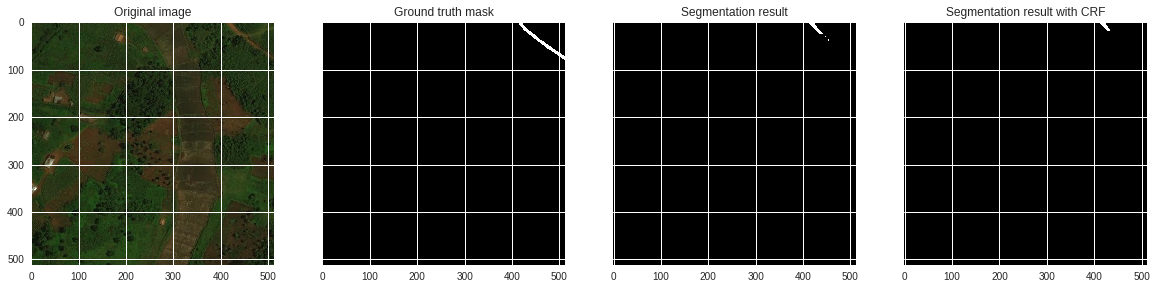

In [65]:
show_crf("10774")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1/1 [==============================] - 10s 10s/step
dice score for prediction without CRF 1.6450860843630604
dice score for prediction with CRF 1.6592077298384416


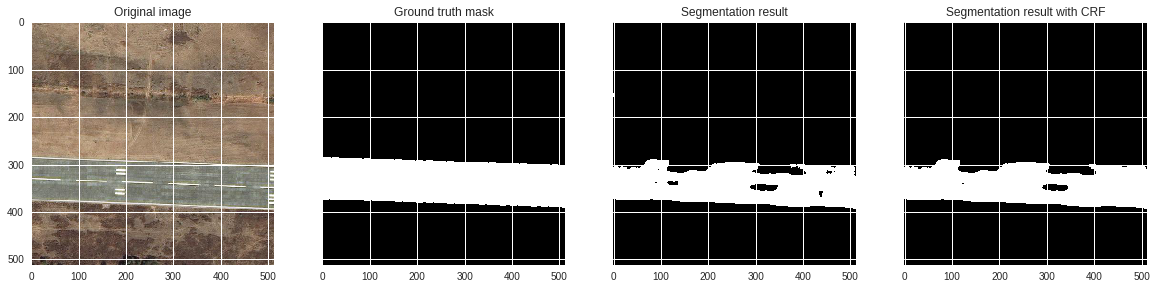

In [66]:
show_crf("39488")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1/1 [==============================] - 10s 10s/step
dice score for prediction without CRF 1.8789132936299395
dice score for prediction with CRF 1.4141768913500412


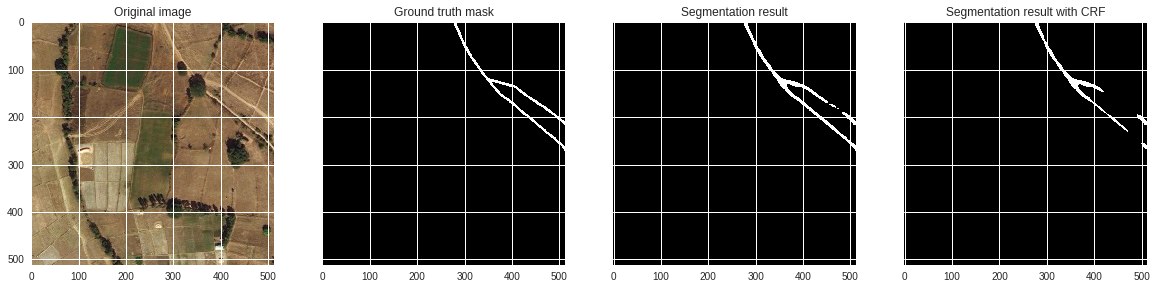

In [67]:
show_crf("10629")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1/1 [==============================] - 10s 10s/step
dice score for prediction without CRF 1.661980922935796
dice score for prediction with CRF 1.6617508308754159


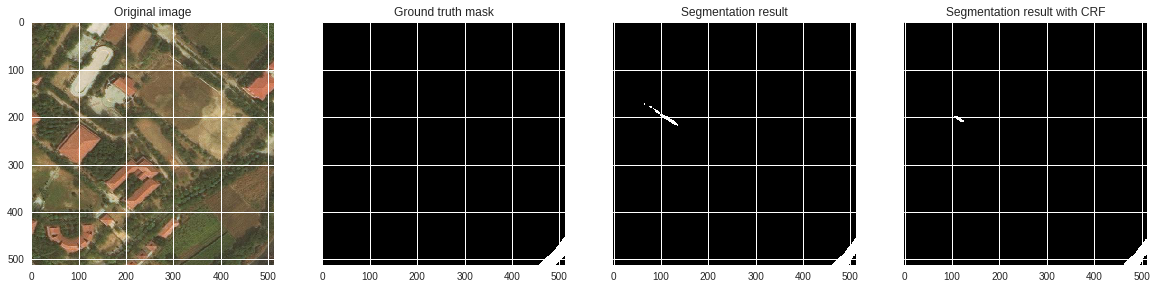

In [58]:
show_crf("10746")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1/1 [==============================] - 10s 10s/step
dice score for prediction without CRF 1.6012043337363322
dice score for prediction with CRF 1.5771940805589133


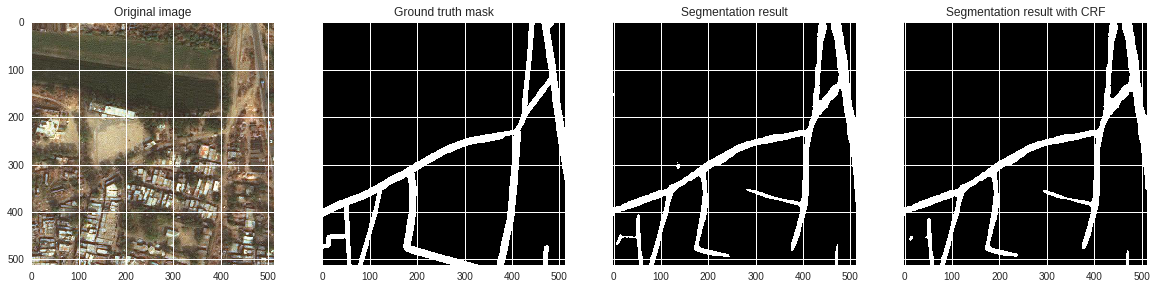

In [68]:
show_crf("1078")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1/1 [==============================] - 10s 10s/step
dice score for prediction without CRF 1.8503397551391465
dice score for prediction with CRF 1.8156356491218824


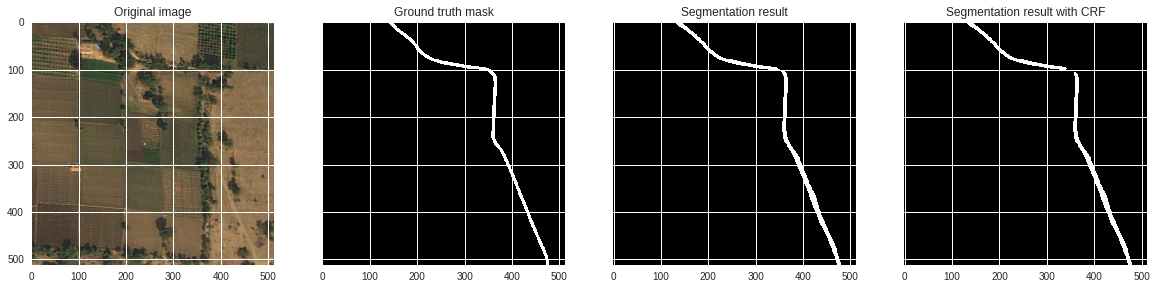

In [69]:
show_crf("10791")

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1/1 [==============================] - 10s 10s/step
dice score for prediction without CRF 1.573966903223219
dice score for prediction with CRF 1.564040718335003


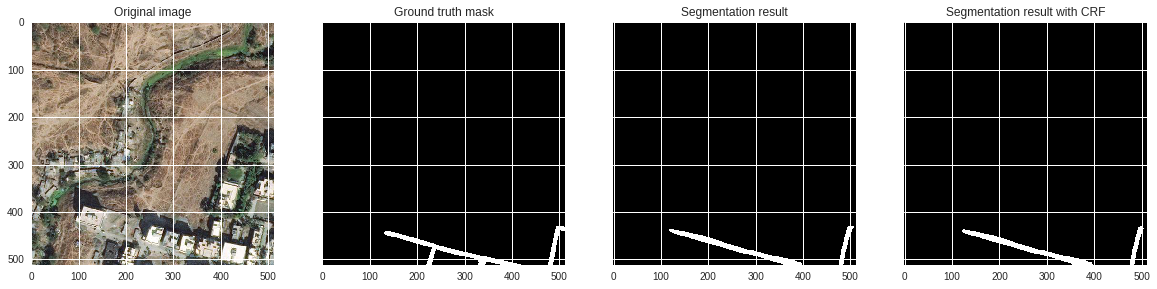

In [71]:

show_crf("11115")

In [0]:

def get_img_id(img_path):
  img_basename = os.path.basename(img_path)
  img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
  return img_id

# Get and resize test images
path_to_val = './Satellite-Segmentation/data/val'
glob_val_imgs = os.path.join(path_to_val, '*_sat.jpg')
val_img_paths = glob(glob_val_imgs)
test_id = [get_img_id(val_img_paths[i]) for i in range(len(val_img_paths))]

def val_img_gen(val_img_paths,img_size=(512,512)):
  for i, val_img_path in enumerate(val_img_paths):
    img = imread(val_img_path)/255
    img = resize(img, img_size, preserve_range = True)
    img = np.reshape(img, (1,512,512,3))
    yield img

In [13]:
# Predict on test
vig = val_img_gen(val_img_paths)

result = model.predict_generator(vig,steps = len(val_img_paths), max_queue_size=5, workers=1, use_multiprocessing=False, verbose=1)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


2169/2169 [==============================] - 747s 344ms/step


In [19]:
# Create submission DataFrame
def create_submission(val_path, csv_name, predictions, image_ids):
    """
    csv_name -> string for csv ("XXXXXXX.csv")
    predictions -> numpyarray of size (num_examples, height, width)
                In this case (num_examples, 512, 512)
    image_ids -> numpyarray or list of size (num_examples,)
    
    predictions[i] should be the prediction of road for image_id[i]
    """
    sub = pd.DataFrame()
    sub['ImageId'] = image_ids
    encodings = []
    num_images = len(image_ids)
    for i in range(num_images):
        ori_img_path = os.path.join(val_path, image_ids[i]+"_sat.jpg")
        origin_image = imread(ori_img_path)
        
        binary_pred = (predictions[i] >= 0.5).astype(int)
        binary_pred = np.reshape(binary_pred, (binary_pred.shape[0],binary_pred.shape[1]))

        result = crf(origin_image,binary_pred)
        if i % 50 == 0:
          print(i)
        encodings.append(rle_encoding(result))
        
    sub['EncodedPixels'] = encodings
    #sub['Height'] = [512]*num_images Nonger needed for DICE Scoring
    #sub['Width'] = [512]*num_images Nonger needed for DICE Scoring
    sub.to_csv(csv_name, index=False)

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    """
    x = numpyarray of size (height, width) representing the mask of an image
    if x[i,j] == 0:
        image[i,j] is not a road pixel
    if x[i,j] != 0:
        image[i,j] is a road pixel
    """
    dots = np.where(x.T.flatten() >0.5)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
  
result = np.reshape(result, (2169, 512, 512))
SUBMISSION_FILE = "id55-15-0.1972_crf1_sub.csv"
create_submission("./Satellite-Segmentation/data/val",SUBMISSION_FILE, result, test_id)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
